In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.finance_utils import get_financial_data

# Load financial data

In [2]:
df = get_financial_data()
df.head()

d:\Grgo\Faks\SequentialComparison-TVZ\utils\finance_utils.py:64: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='max') # Download data
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Daily Return,Lagged Return,Log Return,SMA 14,ATR 14
Date,,,,,,,,,,
2015-01-02,24.261040,24.729263,23.821664,24.718167,212818400,-0.018494,-0.019019,-0.009558,24.666024,0.555241
2015-01-05,23.577574,24.110150,23.391173,24.030263,257142000,-0.018838,-0.009513,-0.028576,24.610865,0.581077
2015-01-06,23.579794,23.839424,23.218085,23.641928,263188400,-0.002628,-0.028171,0.000094,24.579639,0.542243
2015-01-07,23.910431,24.010288,23.677428,23.788382,160423600,0.005131,0.000094,0.013925,24.595490,0.511176
2015-01-08,24.829130,24.886826,24.121248,24.238859,237458000,0.024352,0.014022,0.037703,24.634799,0.531941


# Converting Pandas DataFrame to NumPy ndarray

In [3]:
X = df.to_numpy()
X.shape

(2688, 10)

# Split and scale

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}')

Train: (2150, 10), Test: (538, 10)


# Create sequences

In [5]:
from utils.torch_utils import create_sequence

X_train_seq, y_train_seq = create_sequence(X_train_scaled, input_seq_len=10)
X_test_seq, y_test_seq = create_sequence(X_test_scaled, input_seq_len=7)

print(f'X_train, y_train: {X_train_seq.shape} {y_train_seq.shape}')
print(f'X_test, y_test: {X_test_seq.shape} {y_test_seq.shape}')

X_train, y_train: (2139, 10, 10) (2139, 10)
X_test, y_test: (530, 7, 10) (530, 10)


# Data preparation

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Convert ndarray to torch Tensor
X_train_seq, X_test_seq, y_train_seq, y_test_seq = torch.Tensor(X_train_seq), torch.Tensor(X_test_seq), torch.Tensor(y_train_seq), torch.Tensor(y_test_seq)
# Put tensors to available device
X_train_seq, X_test_seq, y_train_seq, y_test_seq = X_train_seq.to(device), X_test_seq.to(device), y_train_seq.to(device), y_test_seq.to(device)

cuda


In [7]:
from utils.torch_utils import StockDataset

batch_size = 64

dataset_train = StockDataset(X_train_seq, y_train_seq)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

dataset_test = StockDataset(X_test_seq, y_test_seq)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Model definition

In [8]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.positional_embeddings = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        positions = torch.arange(0, seq_len, dtype=torch.long, device=x.device)
        positional_encoding = self.positional_embeddings(positions)
        positional_encoding = positional_encoding.unsqueeze(0)
        return x + positional_encoding


class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, output_dim, num_layers=6, nhead=8, dim_feedforward=2048, dropout=0.1, predict_sequence=False):
        super(TransformerModel, self).__init__()

        self.predict_sequence = predict_sequence

        self.input_proj = nn.Sequential(
                            nn.Linear(input_dim, d_model),
                            nn.ReLU(),
                            nn.Linear(d_model, d_model)
                        )
        
        self.pos_enc = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, seq_len, input_dim)
        """
        B, T, _ = x.size()
        x = self.input_proj(x)
        x = self.pos_enc(x)

        x = self.transformer_encoder(x)

        if self.predict_sequence:
            out = self.fc_out(x)
        else:
            out = self.fc_out(x[:, -1, :])

        return out

In [ ]:
n_features = 10

num_layers = 3
num_heads = 32
d_model = 512
dropout = 0.1

model = TransformerModel(input_dim=n_features, 
                         output_dim=n_features, 
                         d_model=d_model, 
                         nhead=num_heads, 
                         dropout=dropout, 
                         num_layers=num_layers)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# Model training

In [10]:
from datetime import datetime

epochs = 200
train_per_epoch = int(len(dataset_train) / batch_size)

model.train()

for epoch in range(epochs+1):

    epoch_loss = 0

    for (data, target) in dataloader_train:

        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch) % 50 == 0:
        print(f"Epoch {epoch}/{epochs} Avg Loss: {epoch_loss / len(dataloader_train):.4f}")

timestamp = datetime.now().strftime("%d-%m-%Y")
parent_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
save_path = os.path.join(parent_path, f"models/transformer_m2o_{timestamp}.pth")

torch.save(model.state_dict(), save_path)

Epoch 0/200 Avg Loss: 0.4970
Epoch 50/200 Avg Loss: 0.1978
Epoch 100/200 Avg Loss: 0.1025
Epoch 150/200 Avg Loss: 0.0549
Epoch 200/200 Avg Loss: 0.0377


# Model evaluation

In [11]:
model.eval()

with torch.no_grad():

    preds = model(X_test_seq)

    val_loss = criterion(preds, y_test_seq)
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 0.6043149828910828


# Plot train results

(2139, 10)


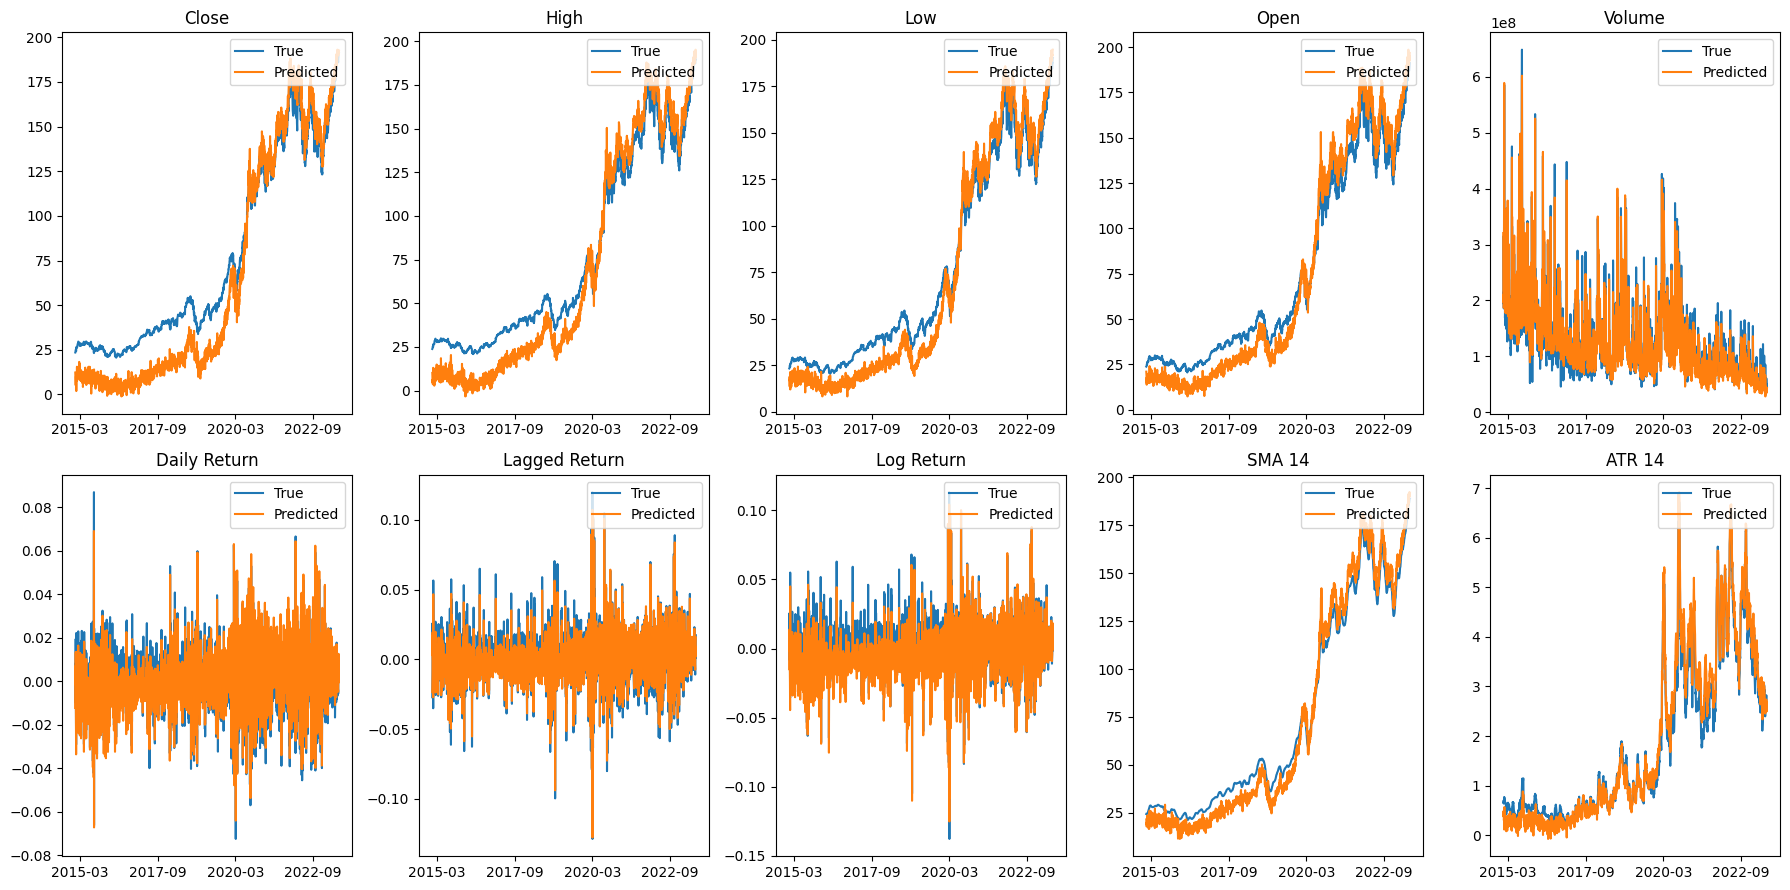

In [12]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

y_true = scaler.inverse_transform(y_train_seq.squeeze(1).cpu().detach().numpy())
y_pred = model(X_train_seq).squeeze(1).cpu().detach().numpy()
print(f'{y_pred.shape}')
y_pred = scaler.inverse_transform(y_pred)

train_dates = df.index[:len(X_train_seq)]

for idx, c in enumerate(df.columns):
    axes[idx].plot(train_dates, y_true[:, idx], color='#1f77b4', label='True')
    axes[idx].plot(train_dates, y_pred[:, idx], color='#ff7f0e', label='Predicted')
    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[idx].xaxis.set_major_locator(mdates.MonthLocator(interval=30))

plt.tight_layout()
plt.show()

# Plotting test results

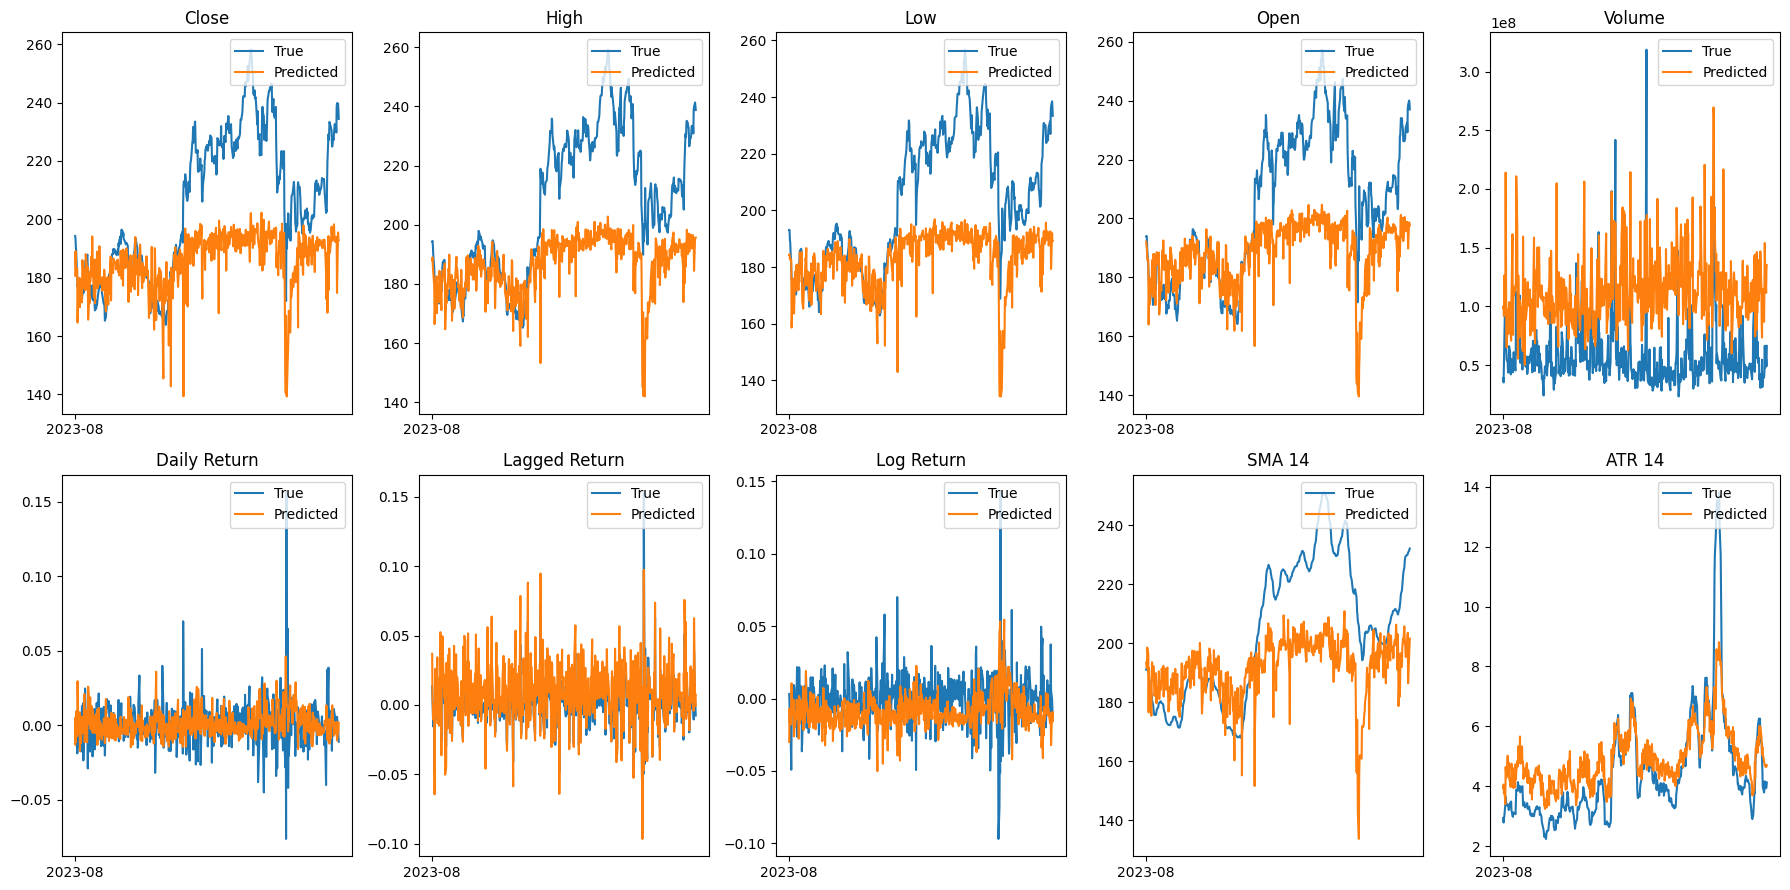

In [13]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

y_true = scaler.inverse_transform(y_test_seq.squeeze(1).cpu().detach().numpy())
y_pred = model(X_test_seq).squeeze(1).cpu().detach().numpy()
y_pred = scaler.inverse_transform(y_pred)

test_dates = df.index[-len(y_true):]

for idx, c in enumerate(df.columns):
    axes[idx].plot(test_dates, y_true[:, idx], color='#1f77b4', label='True')
    axes[idx].plot(test_dates, y_pred[:, idx], color='#ff7f0e', label='Predicted')
    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[idx].xaxis.set_major_locator(mdates.MonthLocator(interval=30))

plt.tight_layout()
plt.show()

# Create sequences

- many-to-many

In [40]:
X_train_seq, y_train_seq = create_sequence(X_train_scaled, input_seq_len=10, target_seq_len=10)
X_test_seq, y_test_seq = create_sequence(X_test_scaled, input_seq_len=7, target_seq_len=7)

print(f'X_train, y_train: {X_train_seq.shape} {y_train_seq.shape}')
print(f'X_test, y_test: {X_test_seq.shape} {y_test_seq.shape}')

X_train, y_train: (2130, 10, 10) (2130, 10, 10)
X_test, y_test: (524, 7, 10) (524, 7, 10)


In [41]:
X_train_seq, X_test_seq, y_train_seq, y_test_seq = torch.Tensor(X_train_seq), torch.Tensor(X_test_seq), torch.Tensor(y_train_seq), torch.Tensor(y_test_seq)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = X_train_seq.to(device), X_test_seq.to(device), y_train_seq.to(device), y_test_seq.to(device)

In [42]:
batch_size = 128

dataset_train = StockDataset(X_train_seq, y_train_seq)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

dataset_test = StockDataset(X_test_seq, y_test_seq)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [43]:
n_features = 10

num_layers = 3
num_heads = 32
d_model = 512
dropout = 0.1

model = TransformerModel(input_dim=n_features, 
                         output_dim=n_features, 
                         d_model=d_model,
                         nhead=num_heads, 
                         dropout=dropout,
                         num_layers=num_layers, 
                         predict_sequence=True)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
epochs = 200
train_per_epoch = int(len(dataset_train) / batch_size)

model.train()

for epoch in range(epochs+1):

    epoch_loss = 0

    for (data, target) in dataloader_train:

        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch) % 10 == 0:
        print(f"Epoch {epoch}/{epochs} Avg Loss: {epoch_loss / len(dataloader_train):.4f}")

timestamp = datetime.now().strftime("%d-%m-%Y")
parent_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
save_path = os.path.join(parent_path, f"models/transformer_m2m_{timestamp}.pth")

torch.save(model.state_dict(), save_path)

Epoch 0/200 Avg Loss: 0.7191
Epoch 10/200 Avg Loss: 0.4885
Epoch 20/200 Avg Loss: 0.4034
Epoch 30/200 Avg Loss: 0.4154
Epoch 40/200 Avg Loss: 0.4354
Epoch 50/200 Avg Loss: 0.3875
Epoch 60/200 Avg Loss: 0.3745
Epoch 70/200 Avg Loss: 0.3661
Epoch 80/200 Avg Loss: 0.3464
Epoch 90/200 Avg Loss: 0.3298
Epoch 100/200 Avg Loss: 0.3294
Epoch 110/200 Avg Loss: 0.3662
Epoch 120/200 Avg Loss: 0.3119
Epoch 130/200 Avg Loss: 0.2890
Epoch 140/200 Avg Loss: 0.2806
Epoch 150/200 Avg Loss: 0.2764
Epoch 160/200 Avg Loss: 0.2621
Epoch 170/200 Avg Loss: 0.2534
Epoch 180/200 Avg Loss: 0.2428
Epoch 190/200 Avg Loss: 0.2549
Epoch 200/200 Avg Loss: 0.2050


In [45]:
model.eval()

with torch.no_grad():
    
    preds = model(X_test_seq.to(device))

    val_loss = criterion(preds, y_test_seq)
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 0.5257760286331177


# Plot train results (one random sequence)

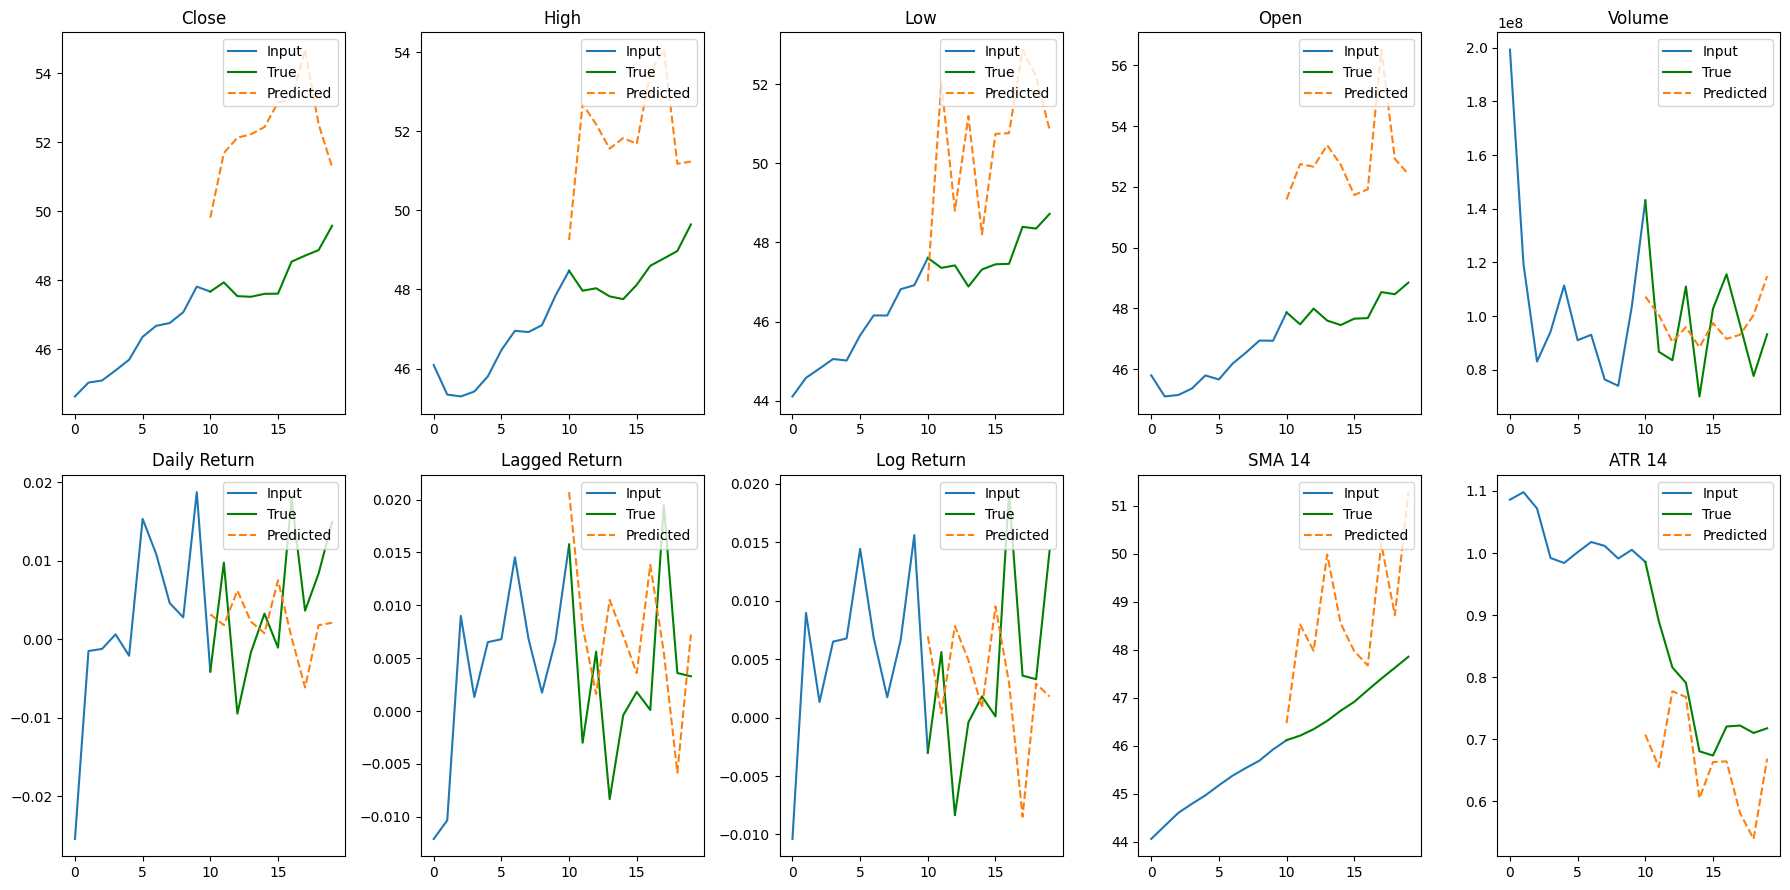

In [52]:
rand_idx = np.random.randint(0, len(X_train_seq))

x = X_train_seq[rand_idx].cpu().detach().numpy()

y_true = y_train_seq[rand_idx].cpu().detach().numpy()
y_pred = model(X_train_seq)[rand_idx].cpu().detach().numpy()

x = scaler.inverse_transform(x)
y_true = scaler.inverse_transform(y_true)
y_pred = scaler.inverse_transform(y_pred)

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

for idx, c in enumerate(df.columns):

    input_seq = x[:, idx]
    true_seq = y_true[:, idx]
    pred_seq = y_pred[:, idx]

    axes[idx].plot(range(len(input_seq)+1), np.hstack((input_seq, true_seq[0])), label='Input', color='#1f77b4')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(true_seq)), true_seq, label='True', color='green')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(pred_seq)), pred_seq, label='Predicted', color='#ff7f0e', linestyle='dashed')

    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')

plt.tight_layout()
plt.show()

# Plot test results (one random sequence)

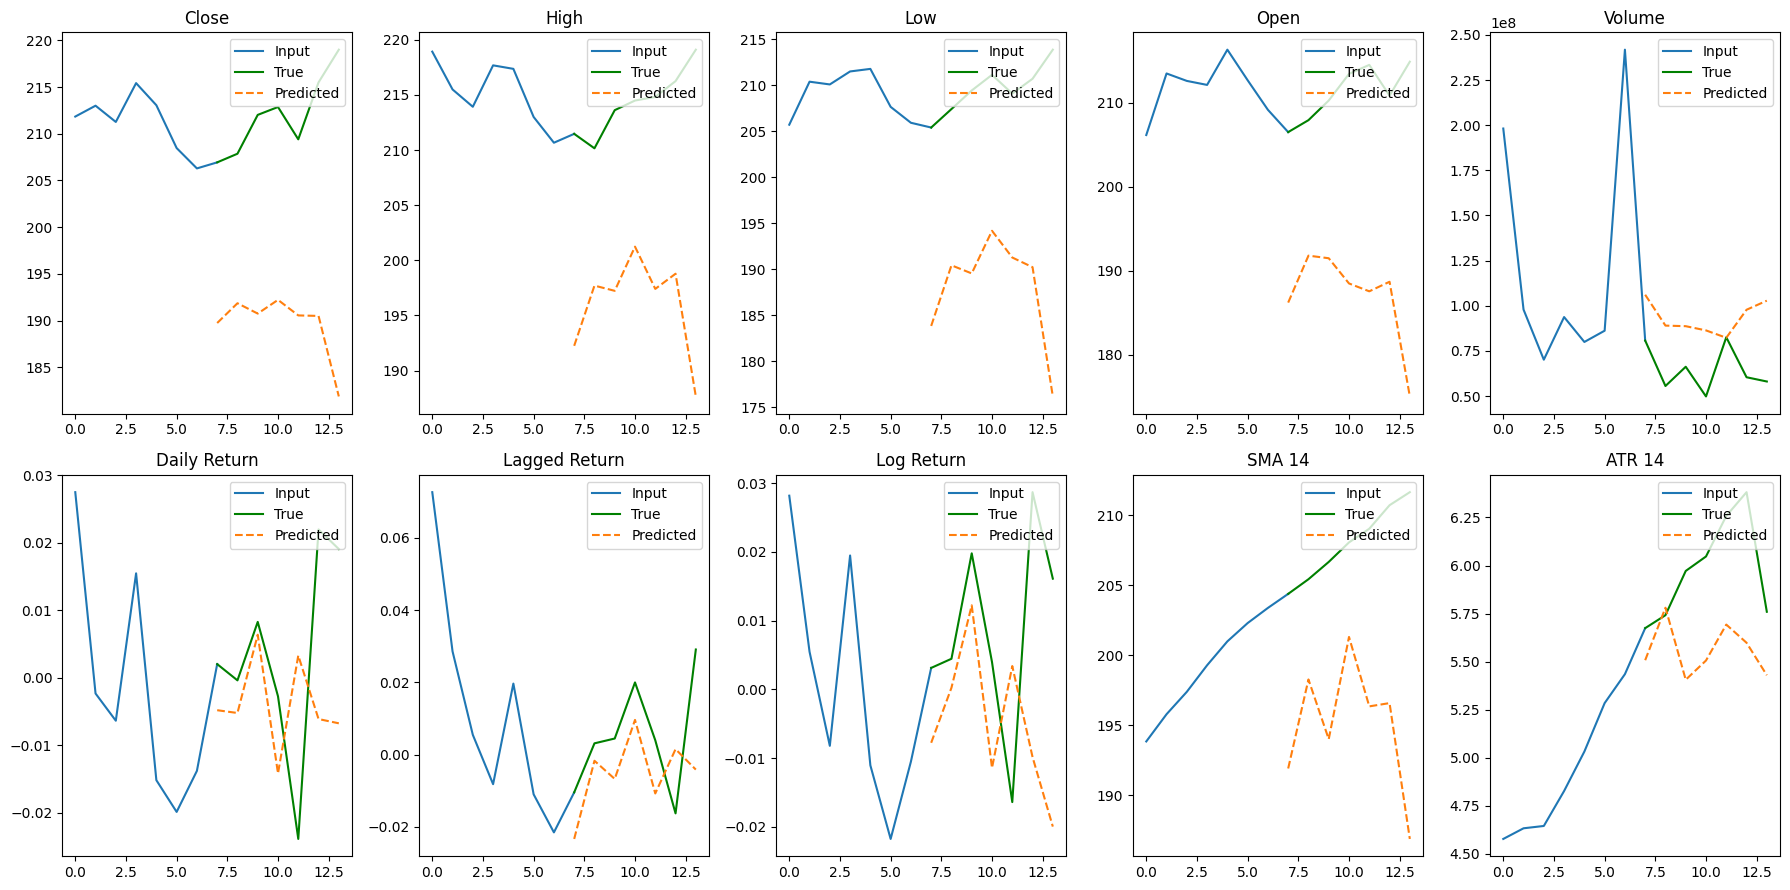

In [47]:
rand_idx = np.random.randint(0, len(X_test_seq))

x = X_test_seq[rand_idx].cpu().detach().numpy()

y_true = y_test_seq[rand_idx].cpu().detach().numpy()
y_pred = model(X_test_seq)[rand_idx].cpu().detach().numpy()

x = scaler.inverse_transform(x)
y_true = scaler.inverse_transform(y_true)
y_pred = scaler.inverse_transform(y_pred)

fig, axes = plt.subplots(2, 5, figsize=(18, 9))
axes = axes.flatten()

for idx, c in enumerate(df.columns):

    input_seq = x[:, idx]
    true_seq = y_true[:, idx]
    pred_seq = y_pred[:, idx]

    axes[idx].plot(range(len(input_seq)+1), np.hstack((input_seq, true_seq[0])), label='Input', color='#1f77b4')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(true_seq)), true_seq, label='True', color='green')
    axes[idx].plot(range(len(input_seq), len(input_seq) + len(pred_seq)), pred_seq, label='Predicted', color='#ff7f0e', linestyle='dashed')

    axes[idx].set_title(c)
    axes[idx].legend(loc='upper right')

plt.tight_layout()
plt.show()